In [3]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import pickle
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments


In [4]:
# Load Dataset

df = pd.read_csv("data/raw/file.csv") 
df.head()


,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [5]:
# cleaned
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) 
    text = re.sub(r"@\w+", "", text) 
    text = re.sub(r"#\w+", "", text) 
    text = re.sub(r"[^A-Za-z0-9\s]+", "", text) 
    text = re.sub(r"\s+", " ", text).strip()  
    return text

df['clean_text'] = df['tweets'].apply(clean_text)

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['labels'])  
df.to_csv("data/processed/tweets_cleaned.csv", index=False)              

print("Preprocessing complete Cleaned dataset saved.")


Preprocessing complete Cleaned dataset saved.


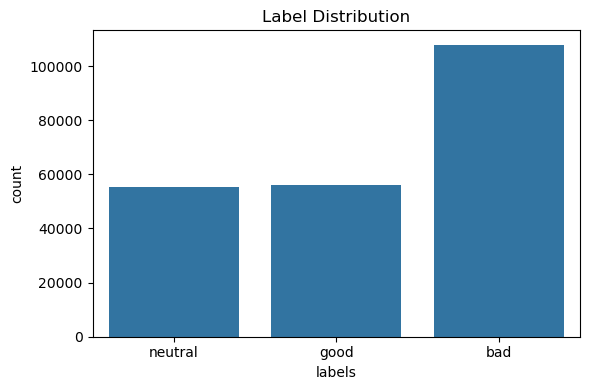

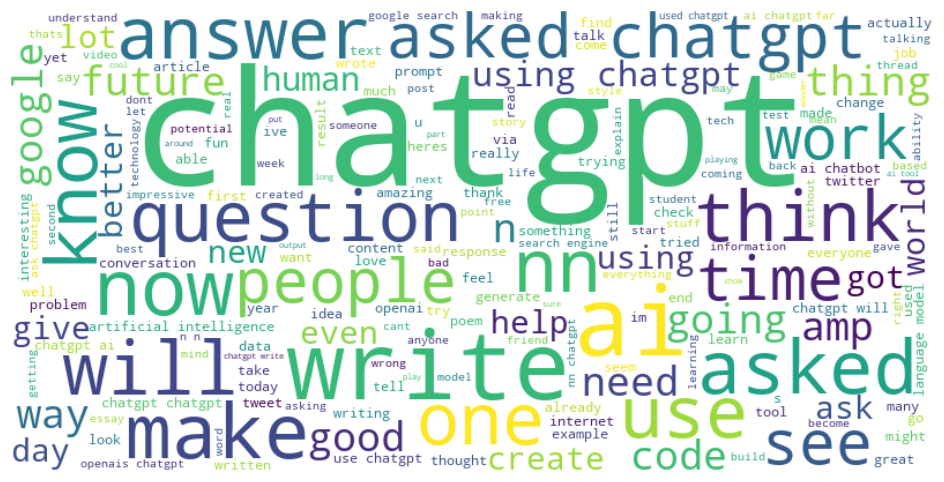

In [6]:
#Exploratory Data Analysis (EDA)

plt.figure(figsize=(6,4))
sns.countplot(x='labels', data=df)
plt.title("Label Distribution")
plt.tight_layout()
plt.savefig("outputs/figures/label_distribution.png")
plt.show()

#Word Cloud
text = " ".join(df['clean_text'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("outputs/figures/wordcloud.png")
plt.show()

In [7]:
#Train-Test Split + TF-IDF

X = df['clean_text']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


In [8]:
X = df['clean_text'].astype(str)
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

tfidf = TfidfVectorizer(
    max_features=1000,    
    stop_words='english',  
    ngram_range=(1, 1),    
    min_df=3               
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF vectorization completed (FAST)")


TF-IDF vectorization completed (FAST)


In [9]:
print("Training Logistic Regression model...")

clf = LogisticRegression(max_iter=500)
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Training Logistic Regression model...

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.92      0.86     21559
           1       0.77      0.71      0.74     11202
           2       0.67      0.53      0.59     11098

    accuracy                           0.77     43859
   macro avg       0.75      0.72      0.73     43859
weighted avg       0.76      0.77      0.76     43859



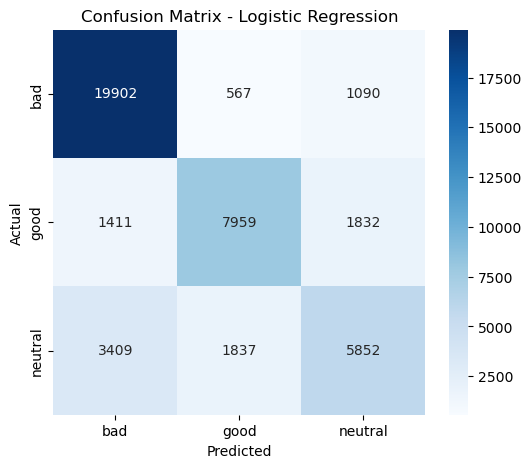

Classical model saved successfully!


In [10]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig("outputs/figures/cm_classical.png")
plt.show()

# Save classical model
with open("models/classical_model.pkl", "wb") as f:
    pickle.dump({
        "model": clf,
        "vectorizer": tfidf,
        "label_encoder": le
    }, f)

print("Classical model saved successfully!")


In [11]:

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)


In [12]:
df_small = df.sample(12000, random_state=42)

X = df_small["clean_text"].astype(str).tolist()
y = df_small["label_encoded"].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(
    X_train,
    truncation=True,
    padding=True,
    max_length=64    
)

test_encodings = tokenizer(
    X_test,
    truncation=True,
    padding=True,
    max_length=64
)


In [14]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, y_train)
test_dataset  = TextDataset(test_encodings, y_test)


In [15]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(set(y))
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds)
    }


In [17]:


training_args = TrainingArguments(
    output_dir="models/transformer_model",

   
    do_train=True,
    do_eval=True,

    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,

    # Optimization
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),

  
    logging_dir="./logs",
    logging_steps=100,
    save_steps=1000,
    save_total_limit=1,

  
    report_to="none"
)


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }


In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()


C:\Users\techmania\AppData\Local\Temp\ipykernel_17156\3502354364.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\techmania\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.994000
200,0.837400
300,0.722300
400,0.664200
500,0.647100
600,0.601900
700,0.545800
800,0.547300
900,0.506900
1000,0.557600


TrainOutput(global_step=1200, training_loss=0.633790512084961, metrics={'train_runtime': 1337.7096, 'train_samples_per_second': 7.176, 'train_steps_per_second': 0.897, 'total_flos': 158963713228800.0, 'train_loss': 0.633790512084961, 'epoch': 1.0})

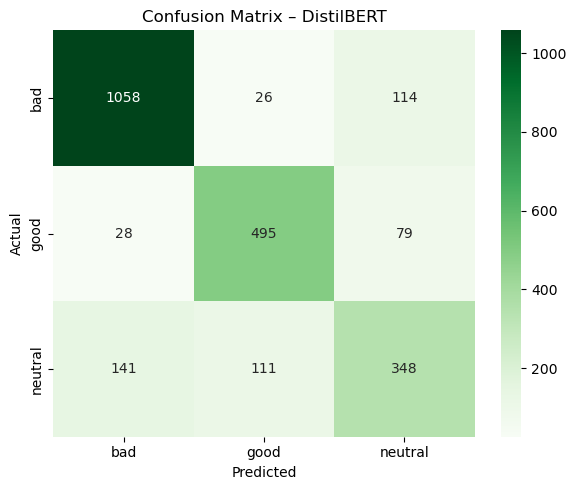

In [20]:

model.eval()
y_pred_bert = []

with torch.no_grad():
    for text in X_test:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
        y_pred_bert.append(pred)

cm_bert = confusion_matrix(y_test, y_pred_bert)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Greens"
)
plt.title("Confusion Matrix – DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("outputs/figures/ConfusionMatrixDistilBERT.png")
plt.show()


In [21]:
trainer.save_model("models/transformer_model")
tokenizer.save_pretrained("models/transformer_model")
print("DistilBERT model saved successfully!")


DistilBERT model saved successfully!
